In [1]:
from PV_Functions import generate_cross_section
from Laplacian_Functions_torch import *
import networkx

from sklearn.cluster import DBSCAN

from tdamapper.learn import MapperAlgorithm
from tdamapper.cover import CubicalCover
from tdamapper.plot import MapperPlot

from tdamapper._plot_plotly import aggregate_graph
from landscapes import Landscape, Lap_Landscape

import pickle
import os
import os.path as osp

from PV_Functions import generate_cross_section_centers
import gudhi 

from pyballmapper import BallMapper
from pyballmapper.plotting import kmapper_visualize

def Laplacian_fun(B22_st, B22_stm1, B22_sm1t, B22_sm1tm1, eye):
    # return B22_stm1@B22_sm1t@(eye-B22_st)@B22_sm1t
    # return B22_sm1t@(eye-B22_st)@B22_sm1t@B22_stm1
    # return B22_sm1t@B22_stm1@(eye-B22_st)@B22_stm1
    # return B22_stm1@(eye-B22_st)@B22_stm1@B22_sm1t
    # return B22_sm1tm1-B22_sm1t-B22_stm1+B22_st

    
    # return B22_stm1@B22_sm1t+B22_sm1t@B22_stm1-2*B22_st
    # return eye-B22_st

    # return B22_stm1@(eye-B22_st)@(eye - B22_sm1tm1 + B22_sm1t)

    # Best
    return B22_sm1t@B22_stm1-B22_st


Generated 249 points, which is within the error margin of 10.00% of the target 250 points.
radius core: 0.033203125


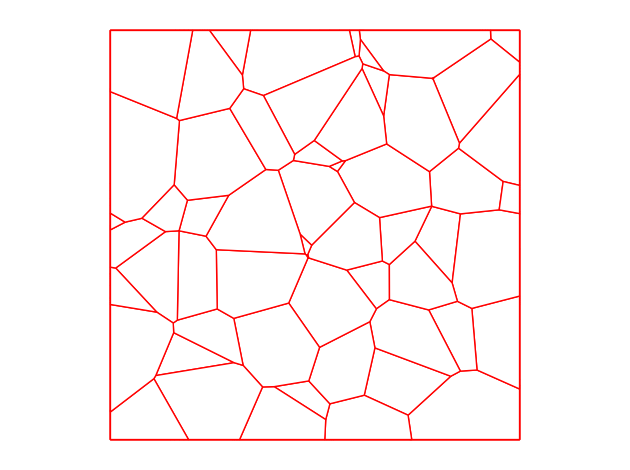

In [18]:
images = generate_cross_section(250, save_images=False, generation_method="HC", 
                                length_of_cube_sides= 1,
                                sample_params={},
                                cross_section_locations=np.arange(0.25,0.3,0.01), 
                                generation_seed=None,
                                color_seed=124, 
                                edge_colors="red")

In [6]:
images[0].save("../figures/PV_cross_section_example.png")

In [5]:
def graph_filtration(graph, node_to_color):
    simplices = []
    # points_covered_by_landmarks = bm.points_covered_by_landmarks
    # print(points_covered_by_landmarks)
    # # print(reversed(list(networkx.enumerate_all_cliques(bm.Graph))))
    # node_to_color = {node_i: np.mean([y_1[point_i] for point_i in points_covered_by_landmarks[node_i]]) for node_i in points_covered_by_landmarks.keys()}
    nodes_done = set()
    simplex_to_nodes = {}
    nodes_to_simplex = {node_i: node_i for node_i in graph.nodes}
    for c in reversed(list(networkx.enumerate_all_cliques(graph))):
        if any([i in nodes_done for i in c]) and len(c) > 2:
            continue
        elif len(c) > 2:
            nodes_done.update(c)

            for i in c:
                nodes_to_simplex[i] = min(c)
            simplices.append(([min(c)], np.mean([node_to_color[i] for i in c])))
            simplex_to_nodes[min(c)] = c
        elif len(c) == 2:
            if c[0] not in nodes_done:
                simplex_to_nodes[c[0]] = [c[0]]
                simplices.append(([c[0]], node_to_color[c[0]]))
                nodes_done.add(c[0])
            if c[1] not in nodes_done:
                simplex_to_nodes[c[1]] = [c[1]]
                simplices.append(([c[1]], node_to_color[c[1]]))
                nodes_done.add(c[1])
            if nodes_to_simplex[c[0]] != nodes_to_simplex[c[1]]:
                avg_0 = np.mean([node_to_color[i] for i in simplex_to_nodes[nodes_to_simplex[c[0]]]])
                avg_1 = np.mean([node_to_color[i] for i in simplex_to_nodes[nodes_to_simplex[c[1]]]])
                simplices.append(([nodes_to_simplex[c[0]], nodes_to_simplex[c[1]]], np.max([avg_0, avg_1])))

    # for s in simplex_to_nodes.keys():
    #     simplices.append([s], np.mean([node_to_color[i] for i in simplex_to_nodes[s]]))

        # if len(c) <= 2:
        # simplices.append((c, np.max([node_to_color[i] for i in c])))

    f = dio.Filtration()
    max_time = 0
    for vertices, time in simplices:
        f.append(dio.Simplex(vertices, time))
        max_time = max(max_time, time)
    f.sort()

    return f, simplex_to_nodes, nodes_to_simplex

def filtration_from_image_ballmapper(image = None, np_array = None, background_value = None, 
                          eps=None, save_to_html=None, use_y_as_color=False, use_new_filtration=False):
    """
    Create a filtration from an image by removing the background and applying Mapper.
    The image should be a PIL Image object.

    Parameters:
    image (PIL.Image): The input image to process.
    background_value: The value to consider as background (optional). If None, it will be calculated as the mean of the image.
    eps (float): The epsilon value for the BallMapper. If None, images_size/80 will be used.
    save_to_html (str): If provided, the resulting Mapper will be saved to an HTML file at this path.
    """

    # Convert the image to a grayscale numpy array
    if image is not None:
        im_gray = 1-np.array(image.convert("L")).astype(int)/255
    else:
        im_gray = np_array

    # Remove the background
    if background_value is None:
        background_value = np.mean(im_gray)
    
    if eps is None:
        eps = im_gray.shape[0] / 80

    X = np.vstack(np.where(im_gray>background_value)).T
    print(X.shape)
    if use_y_as_color:
        y = X[:,0]
    else:
        y = np.array([im_gray[X[i,0], X[i,1]] for i in range(X.shape[0])])


    # Create a Mapper cover and clustering
    bm = BallMapper(X=X.astype(np.float64), eps=eps) #coloring_df = pd.DataFrame(y, columns=["y"]))
    points_covered_by_landmarks = bm.points_covered_by_landmarks

    node_to_color = {node_i: np.mean([y[point_i] for point_i in points_covered_by_landmarks[node_i]]) for node_i in points_covered_by_landmarks.keys()}

    if save_to_html is not None:
        kmapper_visualize(
            bm, coloring_df=pd.DataFrame(y, columns=["y"]), path_html=save_to_html, title="BallMapper Filtration"
        )

    # Create a filtration from the graph
    if use_new_filtration:
        f, simplex_to_nodes, nodes_to_simplex = graph_filtration(bm.Graph, node_to_color)
    else:
        simplices = []
        for c in networkx.enumerate_all_cliques(bm.Graph):
            # if len(c) <= 2:
            simplices.append((c, np.max([node_to_color[i] for i in c])))
        f = dio.Filtration()
        max_time = 0
        for vertices, time in simplices:
            f.append(dio.Simplex(vertices, time))
            max_time = max(max_time, time)
        # print(max_time)
        f.sort()

    return f

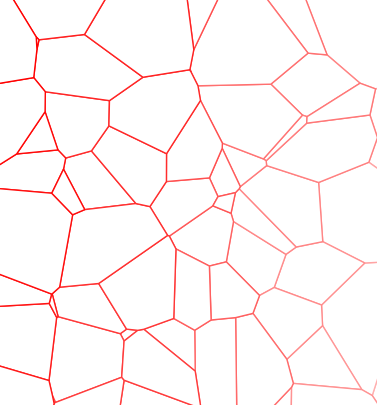

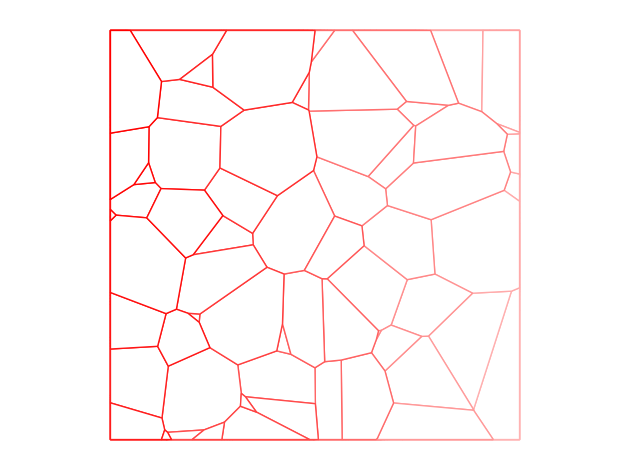

In [775]:
images = generate_cross_section(250, save_images=True, generation_method="PV", 
                                                length_of_cube_sides= 1,
                                                sample_params={},
                                                cross_section_locations=np.arange(0.25,0.3,0.01), 
                                                generation_seed=125,
                                                color_seed=124, 
                                                edge_colors="gradient")

images[0]

In [254]:
filtration_from_image_ballmapper(images[0], eps=25, save_to_html="ballmapper_filtration_25.html")

Filtration with 661 simplices

In [ ]:
def filtration_from_image(image=None, np_array=None, background_value = None, use_y_as_color=False, use_new_filtration=False,
                          cover=CubicalCover(n_intervals=15, overlap_frac=0.3, algorithm="standard"),
                          cluster_algorithm=DBSCAN(eps=5)):
    """
    Create a filtration from an image by removing the background and applying Mapper.
    The image should be a PIL Image object.

    Parameters:
    image (PIL.Image): The input image to process.
    background_value: The value to consider as background (optional). If None, it will be calculated as the mean of the image.
    """

    # Convert the image to a grayscale numpy array
    if image is None:
        im_gray = np_array
    else:
        im_gray = 1-np.array(image.convert("L")).astype(int)/255

    # Remove the background
    if background_value is None:
        background_value = np.mean(im_gray)

    X = np.vstack(np.where(im_gray>background_value)).T
    
    if use_y_as_color:
        y = X[:,0]
    else:
        y = np.array([im_gray[X[i,0], X[i,1]] for i in range(X.shape[0])])

    plt.scatter(X[:,0], X[:,1], c=y, cmap="Reds")
    plt.show()

    # Create a Mapper cover and clustering
    graph = MapperAlgorithm(cover, cluster_algorithm).fit_transform(X, X)

    fig, node_col = MapperPlot(graph, dim=3, seed=42, iterations=60, layout_engine="networkx").plot_plotly(colors=y, cmap="Reds")
    fig.show(config={'scrollZoom': True})

    node_col = aggregate_graph(y, graph, agg=np.nanmean)

    # Create a filtration from the graph
    if use_new_filtration:
        f, simplex_to_nodes, nodes_to_simplex = graph_filtration(graph, node_col)
    else:
        simplices = []
        for c in networkx.enumerate_all_cliques(graph):
            # if len(c) <= 2:
            simplices.append((c, np.max([node_col[i] for i in c])))
        f = dio.Filtration()
        max_time = 0
        for vertices, time in simplices:
            f.append(dio.Simplex(vertices, time))
            max_time = max(max_time, time)
        # print(max_time)
        f.sort()

    return f

NameError: name 'CubicalCover' is not defined

In [760]:
f = filtration_from_image(images[0],
                          cover=CubicalCover(n_intervals=15, overlap_frac=0.3, algorithm="standard"), use_new_filtration=True)

In [70]:
f = filtration_from_image_ballmapper(images[0], eps=10, save_to_html="output.html")

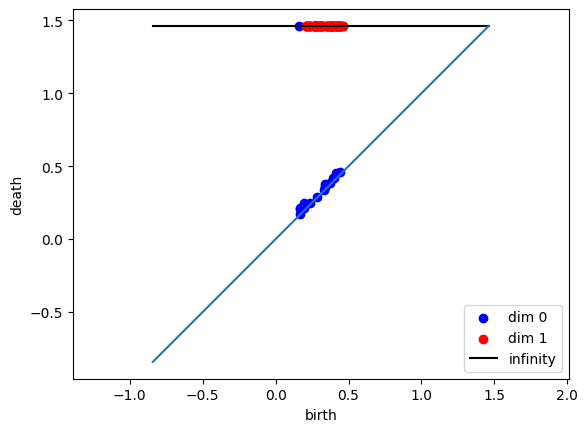

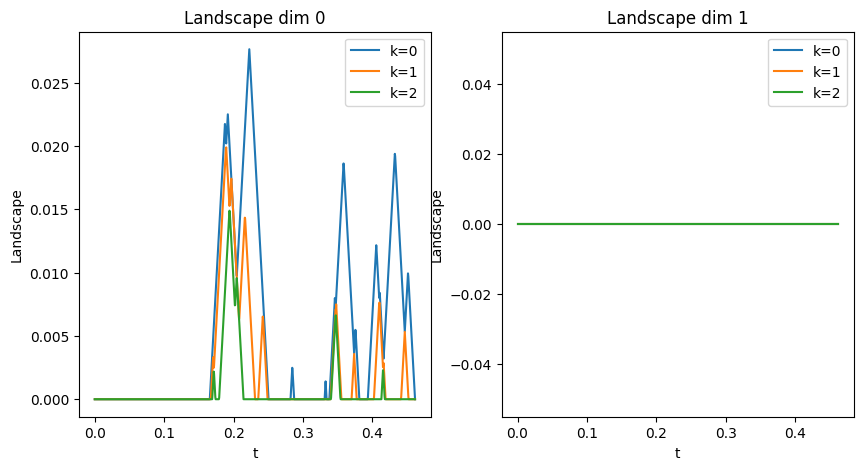

In [763]:


land = Landscape(f, show_diagram=False)
land.show_diagram(show=False)
# plt.savefig("test1.png")
land.plot(max_k=3)
# plt.savefig("test2.png")

(10271, 2)


Computing boundary matrices:   0%|          | 0/1230 [00:00<?, ?it/s]

  0%|          | 0/531 [00:00<?, ?it/s]

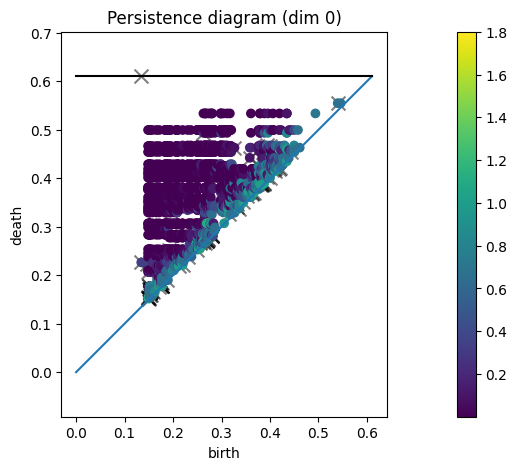

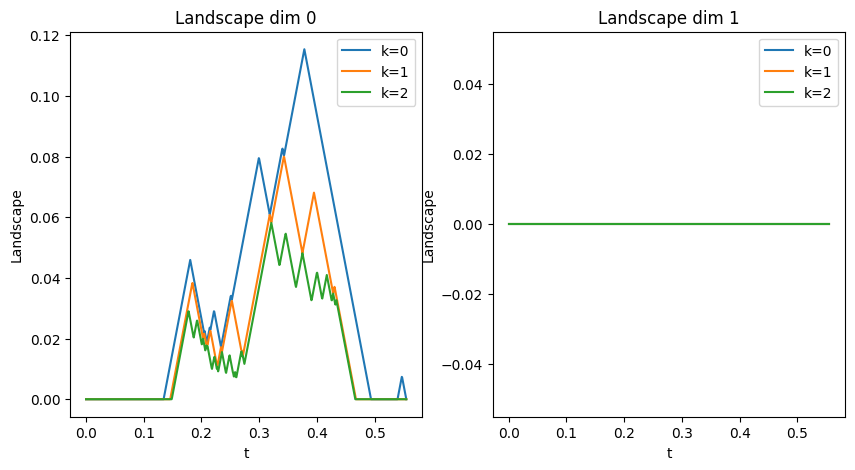

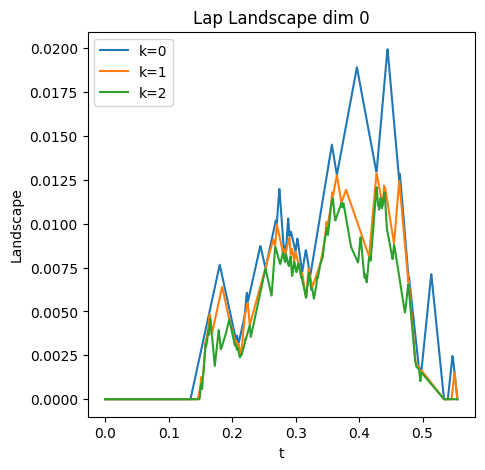

In [780]:
def Laplacian_fun(B22_st, B22_stm1, B22_sm1t, B22_sm1tm1, eye):
    # return B22_stm1@B22_sm1t@(eye-B22_st)@B22_sm1t
    # return B22_sm1t@(eye-B22_st)@B22_sm1t@B22_stm1
    # return B22_sm1t@B22_stm1@(eye-B22_st)@B22_stm1
    # return B22_stm1@(eye-B22_st)@B22_stm1@B22_sm1t
    # return B22_sm1tm1-B22_sm1t-B22_stm1+B22_st

    
    # return B22_stm1@B22_sm1t+B22_sm1t@B22_stm1-2*B22_st
    # return eye-B22_st

    # return B22_stm1@(eye-B22_st)@(eye - B22_sm1tm1 + B22_sm1t)

    # Best
    return B22_sm1t@B22_stm1-B22_st

    # return B22_sm1t+B22_stm1-B22_st-B22_sm1tm1
# f = filtration_from_image(images[0],
#                           cover=CubicalCover(n_intervals=55, overlap_frac=0.3, algorithm="standard"))
f = filtration_from_image_ballmapper(images[0], eps=5, use_new_filtration=True)

lap_land = Lap_Landscape(f, show_trace_diagram=False, min_dim=0, max_dim=0, Laplacian_fun=Laplacian_fun,compute_only_trace=True)
land = Landscape(f, show_diagram=False)
land.plot(max_k=3)
lap_land.plot(max_k=3)

In [2]:

def poissonPointProcess(intensity, xMin=0, xMax=1, yMin=0, yMax=1, plot=False, seed=None):
    xDelta=xMax-xMin;yDelta=yMax-yMin #rectangle dimensions
    areaTotal=xDelta*yDelta
    if seed is not None:
        np.random.seed(seed) #set the random seed for reproducibility

    #Simulate a Poisson point process
    numbPoints = np.random.poisson(intensity*areaTotal);#Poisson number of points
    xx = xDelta*np.random.uniform(0,1,numbPoints)+xMin;#x coordinates of Poisson points
    yy = yDelta*np.random.uniform(0,1,numbPoints)+yMin;#y coordinates of Poisson points

    #Plot the points
    if plot:
        plt.figure()
        plt.scatter(xx,yy,s=2)
        plt.xlim(xMin,xMax)
        plt.ylim(yMin,yMax)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title(f'Poisson Point Process, n={numbPoints}')
        plt.show()
    return xx,yy

def PointProcessFiltration(n, xMin=0, xMax=1, yMin=0, yMax=1, plot=False, seed=None, max_r=None, method = "poisson"):
    if max_r is None:
        max_r = max(xMax-xMin, yMax-yMin)
    
    # xx, yy = poissonPointProcess(intensity, xMin=xMin, xMax=xMax, yMin=yMin, yMax = yMax, seed=seed)
    if method == "poisson":
        points = generate_cross_section_centers(n, generation_seed = seed, generation_method = "PV", cross_section_locations=[0.5])[0.5]
        if seed is not None:
            rng = np.random.default_rng(seed)
        else:
            rng = np.random
        xx = rng.uniform(xMin,xMax,points.shape[0]);#x coordinates of Poisson points
        yy = rng.uniform(yMin,yMax,points.shape[0]);#y coordinates of Poisson points
    else:
        points = generate_cross_section_centers(n, generation_seed = seed, generation_method = method, cross_section_locations=[0.5])[0.5]
        xx = points[:, 0]
        yy = points[:, 1]
    numbPoints = len(xx)
    print(f"Number of points: {numbPoints}")

    if plot:
        plt.figure()
        plt.scatter(xx,yy,s=2)
        plt.xlim(xMin,xMax)
        plt.ylim(yMin,yMax)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title(f'{method} Process, n={numbPoints}')
        plt.show()

    # f = dio.fill_rips(np.array([xx, yy]).T, 1, max_r)
    f = dio.Filtration()
    tree = gudhi.alpha_complex.AlphaComplex(points=np.array([xx, yy]).T).create_simplex_tree(max_alpha_square=max_r)
    for vertices, t in tree.get_filtration():
        f.append(dio.Simplex(vertices, t))
    f.sort()
    return f

def Laplacian_fun(B22_st, B22_stm1, B22_sm1t, B22_sm1tm1, eye):
    # return B22_stm1@B22_sm1t@(eye-B22_st)@B22_sm1t
    # return B22_sm1t@(eye-B22_st)@B22_sm1t@B22_stm1
    # return B22_sm1t@B22_stm1@(eye-B22_st)@B22_stm1
    # return B22_stm1@(eye-B22_st)@B22_stm1@B22_sm1t
    # return B22_sm1tm1-B22_sm1t-B22_stm1+B22_st

    
    # return B22_stm1@B22_sm1t+B22_sm1t@B22_stm1-2*B22_st
    # return eye-B22_st

    # return B22_stm1@(eye-B22_st)@(eye - B22_sm1tm1 + B22_sm1t)

    # Best
    return B22_sm1t@B22_stm1-B22_st

In [ ]:
max_r = 1

for method in ["PV", "cluster", "HC"]:
    seed_bar = tqdm(range(100))
    for seed in seed_bar:
        try:
            seed_bar.set_description(f"Method: {method}, Seed: {seed}")
            images = generate_cross_section(250, save_images=True, generation_method=method, 
                                            length_of_cube_sides= 1,
                                            sample_params={},
                                            cross_section_locations=np.arange(0.25,0.3,0.01), 
                                            generation_seed=seed,
                                            color_seed=124, 
                                            edge_colors="gradient")

            f = filtration_from_image(images[0],
                                    cover=CubicalCover(n_intervals=25, overlap_frac=0.3, algorithm="standard"))

            land = Landscape(f, show_diagram=False, max_t=max_r)
            # land.show_diagram(show=False)
            # im_name = f"{method}_{seed}"
            # plt.savefig("../figures/small_tests_Mapper_gradient/" + im_name + "_normal_diagram.png")
            # land.plot()
            # plt.savefig("../figures/small_tests_Mapper_gradient/" + im_name + "_normal_landscape.png")

            lap_land = Lap_Landscape(f, show_trace_diagram=False, min_dim=0, max_dim = 1, Laplacian_fun=Laplacian_fun,compute_only_trace=True, max_t=max_r)
            # lap_land.show_trace_diagram(show=False)
            # plt.savefig("../figures/small_tests_Mapper_gradient/" + im_name + "_lap_diagram.png")
            # lap_land.plot()
            # plt.savefig("../figures/small_tests_Mapper_gradient/" + im_name + "_lap_landscape.png")
            plt.close("all")

            with open("../landscapes/incl_zero_dim/" + f"{method}_{seed}_grad_norm.pkl", "wb") as f:
                land.f = None
                pickle.dump(land, f)

            with open("../landscapes/incl_zero_dim/" + f"{method}_{seed}_grad_lap.pkl", "wb") as f:
                lap_land.f = None
                pickle.dump(lap_land, f)
        except:
            print(f"Error processing method {method} with seed {seed}. Skipping...")
            continue


for method in ["PV", "cluster", "HC"]:
    seed_bar = tqdm(range(100))
    for seed in seed_bar:
        try:
            print(f"PP Method: {method}, Seed: {seed}")
            f = PointProcessFiltration(250, plot=True, seed=seed, method=method, max_r=max_r)
            # f = filtration_from_image(images[0],
            #                         cover=CubicalCover(n_intervals=30, overlap_frac=0.3, algorithm="standard"))

            land = Landscape(f, show_diagram=False, max_t=max_r)
            # land.show_diagram(show=False, limits=[0, max_r, 0, max_r])
            # im_name = f"{method}_{seed}"
            # plt.savefig("../figures/small_tests_PP_alpha/" + im_name + "_normal_diagram.png")
            # land.plot()
            # plt.savefig("../figures/small_tests_PP_alpha/" + im_name + "_normal_landscape.png")

            lap_land = Lap_Landscape(f, show_trace_diagram=False, min_dim=1, Laplacian_fun=Laplacian_fun,compute_only_trace=True, max_t=max_r)
            # lap_land.show_trace_diagram(show=False)
            # plt.savefig("../figures/small_tests_PP_alpha/" + im_name + "_lap_diagram.png")
            # lap_land.plot()
            # plt.savefig("../figures/small_tests_PP_alpha/" + im_name + "_lap_landscape.png")
            plt.close("all")

            with open("../landscapes/" + f"{method}_{seed}_alpha_norm.pkl", "wb") as f:
                pickle.dump(land.__mult__(1), f)

            with open("../landscapes/" + f"{method}_{seed}_alpha_lap.pkl", "wb") as f:
                pickle.dump(lap_land.__mult__(1), f)
        except:
            print(f"Error processing PP method {method} with seed {seed}. Skipping...")
            continue


# for method in ["PV", "cluster", "HC"]:
#     seed_bar = tqdm(range(100))
#     for seed in seed_bar:
#         try:
#             seed_bar.set_description(f"random Method: {method}, Seed: {seed}")
#             images = generate_cross_section(250, save_images=True, generation_method=method, 
#                                             length_of_cube_sides= 1,
#                                             sample_params={},
#                                             cross_section_locations=np.arange(0.25,0.3,0.01), 
#                                             generation_seed=seed,
#                                             color_seed=124, 
#                                             edge_colors="random")

#             f = filtration_from_image(images[0],
#                                     cover=CubicalCover(n_intervals=25, overlap_frac=0.3, algorithm="standard"))

#             land = Landscape(f, show_diagram=False, max_t=max_r)
#             # land.show_diagram(show=False)
#             # im_name = f"{method}_{seed}"
#             # plt.savefig("../figures/small_tests_Mapper_gradient/" + im_name + "_normal_diagram.png")
#             # land.plot()
#             # plt.savefig("../figures/small_tests_Mapper_gradient/" + im_name + "_normal_landscape.png")

#             lap_land = Lap_Landscape(f, show_trace_diagram=False, min_dim=1, Laplacian_fun=Laplacian_fun,compute_only_trace=True, max_t=max_r)
#             # lap_land.show_trace_diagram(show=False)
#             # plt.savefig("../figures/small_tests_Mapper_gradient/" + im_name + "_lap_diagram.png")
#             # lap_land.plot()
#             # plt.savefig("../figures/small_tests_Mapper_gradient/" + im_name + "_lap_landscape.png")
#             plt.close("all")

#             with open("../landscapes/" + f"{method}_{seed}_random_norm.pkl", "wb") as f:
#                 pickle.dump(land.__mult__(1), f)

#             with open("../landscapes/" + f"{method}_{seed}_random_lap.pkl", "wb") as f:
#                 pickle.dump(lap_land.__mult__(1), f)
#         except:
#             print(f"Error processing random method {method} with seed {seed}. Skipping...")
#             continue


In [ ]:
point_dict = {}
path_to_landscapes = "../ballmapper_landscapes/eps_15"

for color in sorted(os.listdir(path_to_landscapes)):
    point_dict[color] = {}
    for method in sorted(os.listdir(os.path.join(path_to_landscapes, color))):
        point_dict[color][method] = {"laplacian": [], "normal": []}
        for land_file in tqdm(sorted(os.listdir(os.path.join(path_to_landscapes, color, method)))):
            with open(osp.join(path_to_landscapes, color, method, land_file), "rb") as f:
                land = pickle.load(f)
            if land_file.split("_")[0] == "normal":
                point_dict[color][method][land_file.split("_")[0]].append(land.points)
            else:
                point_dict[color][method][land_file.split("_")[0]].append(land.points)

  0%|          | 0/384 [00:00<?, ?it/s]

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x73415ae501f0>>
Traceback (most recent call last):
  File "/home/siroj/miniconda3/envs/thesis/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [57]:
with open("../ballmapper_landscapes/point_dict.pkl", "wb") as f:
    pickle.dump(point_dict, f)

In [3]:
with open("../ballmapper_landscapes/point_dict.pkl", "rb") as f:
    point_dict = pickle.load(f)

In [4]:
ss.wasserstein_distance_nd(point_dict["alpha"]["PV"]["laplacian"][0][1], point_dict["alpha"]["PV"]["laplacian"][1][1])

0.052820017706356456

In [7]:
wasserstein_dict = {}

for q in range(2):
    wasserstein_dict[q] = {}
    for color in point_dict.keys():
        wasserstein_dict[q][color] = {}
        if color == "alpha":
            start_from = 100
        else:
            start_from = 50
        for initial_method in tqdm(point_dict[color].keys(), leave=False):
            wasserstein_dict[q][color][initial_method] = {}
            
            intial_point_clouds_normal = point_dict[color][initial_method]["normal"][:start_from]
            intial_point_clouds_lap = point_dict[color][initial_method]["laplacian"][:start_from]
            # average_land = np.mean(land_dict[color][initial_method]["normal"][:start_from])
            # average_lap_land = np.mean(land_dict[color][initial_method]["laplacian"][:start_from])

            for new_method in point_dict[color].keys():
                wasserstein_dict[q][color][initial_method][new_method] = {"normal": [], "laplacian": []}
                normal_bar = tqdm(point_dict[color][new_method]["normal"][start_from:], leave=False, desc="normal distances")
                for new_cloud in normal_bar:
                    distances = []
                    for cloud_i, initial_cloud in enumerate(intial_point_clouds_normal):
                        normal_bar.set_description(f"Normal ({cloud_i}/{len(intial_point_clouds_normal)}): size initial cloud: {len(initial_cloud[q])}, size new cloud: {len(new_cloud[q])}")
                        distances.append(ss.wasserstein_distance_nd(initial_cloud[q], new_cloud[q]))
                    wasserstein_dict[q][color][initial_method][new_method]["normal"].append(np.mean(distances))
                
                lap_bar = tqdm(point_dict[color][new_method]["laplacian"][start_from:], leave=False, desc="lap distances")
                for new_cloud in lap_bar:
                    distances = []
                    for cloud_i, initial_cloud in enumerate(intial_point_clouds_lap):
                        lap_bar.set_description(f"Lap ({cloud_i}/{len(intial_point_clouds_lap)}): size initial cloud: {len(initial_cloud[q])}, size new cloud: {len(new_cloud[q])}")
                        distances.append(ss.wasserstein_distance_nd(initial_cloud[q], new_cloud[q]))
                    wasserstein_dict[q][color][initial_method][new_method]["laplacian"].append(np.mean(distances))
            

  0%|          | 0/3 [00:00<?, ?it/s]

normal distances:   0%|          | 0/92 [00:00<?, ?it/s]

lap distances:   0%|          | 0/92 [00:00<?, ?it/s]

normal distances:   0%|          | 0/100 [00:00<?, ?it/s]

lap distances:   0%|          | 0/100 [00:00<?, ?it/s]

normal distances:   0%|          | 0/100 [00:00<?, ?it/s]

lap distances:   0%|          | 0/100 [00:00<?, ?it/s]

normal distances:   0%|          | 0/92 [00:00<?, ?it/s]

lap distances:   0%|          | 0/92 [00:00<?, ?it/s]

normal distances:   0%|          | 0/100 [00:00<?, ?it/s]

lap distances:   0%|          | 0/100 [00:00<?, ?it/s]

normal distances:   0%|          | 0/100 [00:00<?, ?it/s]

lap distances:   0%|          | 0/100 [00:00<?, ?it/s]

normal distances:   0%|          | 0/92 [00:00<?, ?it/s]

lap distances:   0%|          | 0/92 [00:00<?, ?it/s]

normal distances:   0%|          | 0/100 [00:00<?, ?it/s]

lap distances:   0%|          | 0/100 [00:00<?, ?it/s]

normal distances:   0%|          | 0/100 [00:00<?, ?it/s]

lap distances:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

normal distances:   0%|          | 0/47 [00:00<?, ?it/s]

lap distances:   0%|          | 0/47 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [9]:
with open("../ballmapper_landscapes/wasserstein_dict.pkl", "wb") as f:
    pickle.dump(wasserstein_dict, f)
# wasserstein_dict

In [96]:
len(point_dict["alpha"]["PV"]["laplacian"][0][1])

112

KeyError: 'cluster'

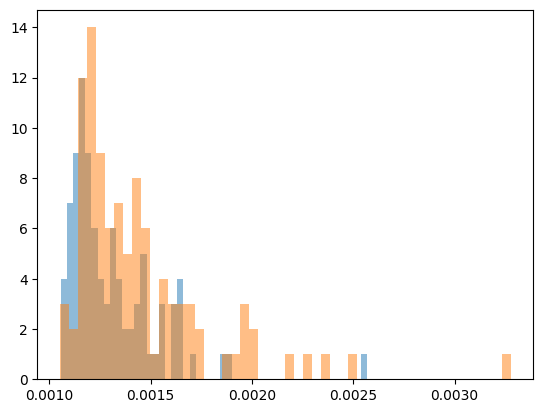

In [77]:
plt.hist(wasserstein_dict[1]["alpha"]["HC"]["HC"]["normal"], bins=50, alpha=0.5, label="HC")
plt.hist(wasserstein_dict[1]["alpha"]["HC"]["PV"]["normal"], bins=50, alpha=0.5, label="PV")
plt.hist(wasserstein_dict[1]["alpha"]["HC"]["cluster"]["normal"], bins=50, alpha=0.5, label="PV")

In [6]:
land_dict = {}

for eps in [10, 15, 20, 25]:

    path_to_landscapes = f"../ballmapper_landscapes/eps_{eps}"
    land_dict[eps] = {}
    for color in sorted(os.listdir(path_to_landscapes)):
        land_dict[eps][color] = {}
        for method in sorted(os.listdir(os.path.join(path_to_landscapes, color))):
            land_dict[eps][color][method] = {"laplacian": [], "normal": []}
            for land_file in tqdm(sorted(os.listdir(os.path.join(path_to_landscapes, color, method))), leave=False, desc=f"Processing eps {eps}, {color} {method} landscapes"):
                with open(osp.join(path_to_landscapes, color, method, land_file), "rb") as f:
                    land = pickle.load(f)
                if land_file.split("_")[0] == "normal":
                    land_dict[eps][color][method][land_file.split("_")[0]].append(land.__mult__(1))
                else:
                    land_dict[eps][color][method][land_file.split("_")[0]].append(land.sum_k())


Processing eps 10, gradient PV landscapes:   0%|          | 0/84 [00:00<?, ?it/s]

Processing eps 10, random_124 HC landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 10, random_124 PV landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 10, random_124 cluster landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 15, alpha HC landscapes:   0%|          | 0/384 [00:00<?, ?it/s]

Processing eps 15, alpha PV landscapes:   0%|          | 0/400 [00:00<?, ?it/s]

Processing eps 15, alpha cluster landscapes:   0%|          | 0/400 [00:00<?, ?it/s]

Processing eps 15, gradient HC landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 15, gradient PV landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 15, gradient cluster landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 15, random_124 HC landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 15, random_124 PV landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 15, random_124 cluster landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 20, gradient HC landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 20, gradient PV landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 20, gradient cluster landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 20, random_124 HC landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 20, random_124 PV landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 20, random_124 cluster landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 25, gradient HC landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 25, gradient PV landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 25, gradient cluster landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 25, random_124 HC landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 25, random_124 PV landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 25, random_124 cluster landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

In [8]:
with open(f"../ballmapper_landscapes/land_dict_eps_10_25.pkl", "wb") as f:
    pickle.dump(land_dict, f)

In [7]:
land_dict_new_filtration = {}

for eps in [10, 15, 20, 25]:

    path_to_landscapes = f"../ballmapper_landscapes_new_filtration/eps_{eps}"
    land_dict_new_filtration[eps] = {}
    for color in sorted(os.listdir(path_to_landscapes)):
        land_dict_new_filtration[eps][color] = {}
        for method in sorted(os.listdir(os.path.join(path_to_landscapes, color))):
            land_dict_new_filtration[eps][color][method] = {"laplacian": [], "normal": []}
            for land_file in tqdm(sorted(os.listdir(os.path.join(path_to_landscapes, color, method))), leave=False, desc=f"Processing eps {eps}, {color} {method} landscapes"):
                with open(osp.join(path_to_landscapes, color, method, land_file), "rb") as f:
                    land = pickle.load(f)
                if land_file.split("_")[0] == "normal":
                    land_dict_new_filtration[eps][color][method][land_file.split("_")[0]].append(land.__mult__(1))
                else:
                    land_dict_new_filtration[eps][color][method][land_file.split("_")[0]].append(land.sum_k())

Processing eps 10, gradient PV landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 10, gradient cluster landscapes:   0%|          | 0/138 [00:00<?, ?it/s]

Processing eps 10, random_124 HC landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 10, random_124 PV landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 10, random_124 cluster landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 15, gradient HC landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 15, gradient PV landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 15, gradient cluster landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 15, random_124 HC landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 15, random_124 PV landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 15, random_124 cluster landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 20, gradient HC landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 20, gradient PV landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 20, gradient cluster landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 20, random_124 HC landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 20, random_124 PV landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 20, random_124 cluster landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 25, gradient HC landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 25, gradient PV landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 25, gradient cluster landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 25, random_124 HC landscapes:   0%|          | 0/194 [00:00<?, ?it/s]

Processing eps 25, random_124 PV landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

Processing eps 25, random_124 cluster landscapes:   0%|          | 0/200 [00:00<?, ?it/s]

In [9]:
with open("../ballmapper_landscapes_new_filtration/land_dict_eps_10_25.pkl", "wb") as f:
    pickle.dump(land_dict_new_filtration, f)

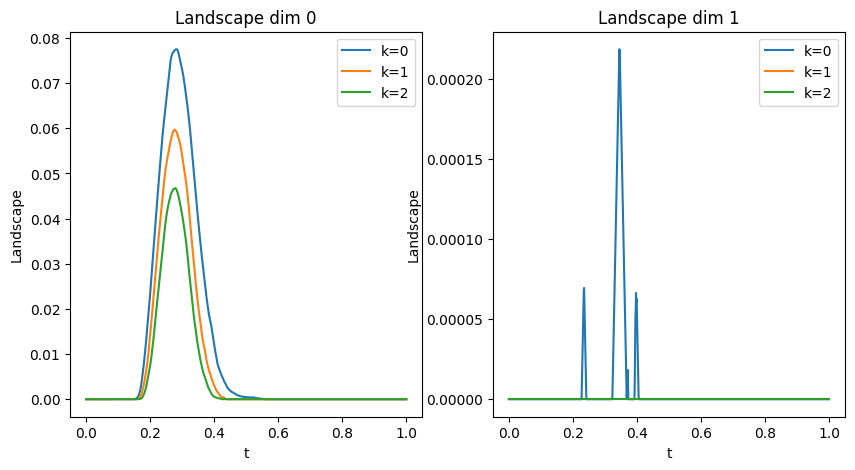

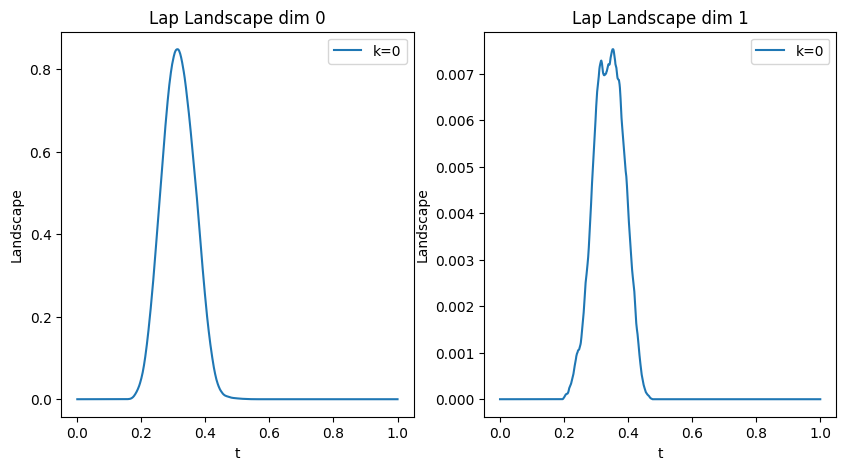

In [13]:
color = "random_124"
eps = 20

np.mean(land_dict[eps][color]["PV"]["normal"]).plot()
np.mean(land_dict[eps][color]["PV"]["laplacian"]).plot()

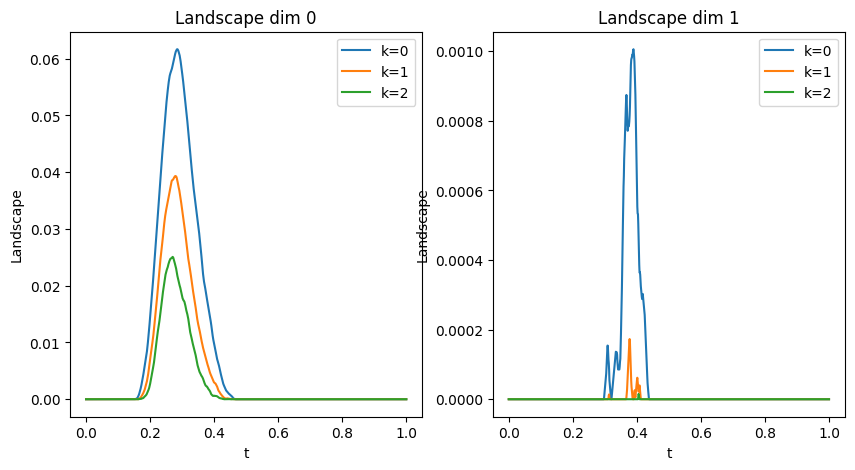

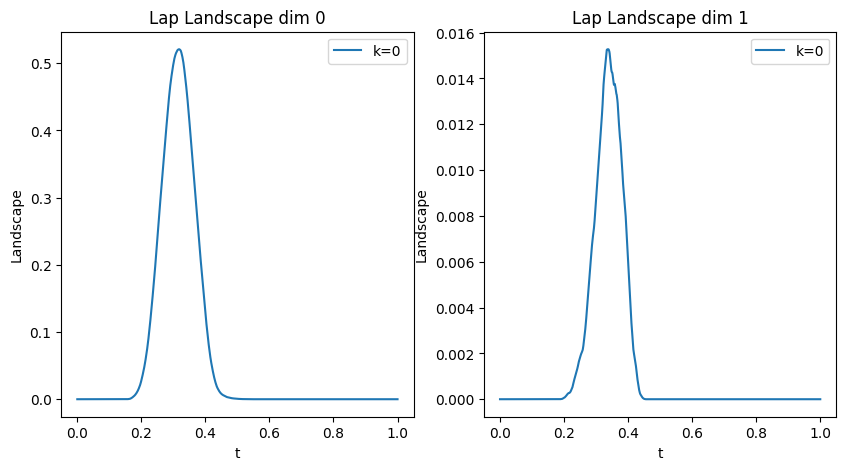

In [14]:
np.mean(land_dict[eps][color]["cluster"]["normal"]).plot()
np.mean(land_dict[eps][color]["cluster"]["laplacian"]).plot()

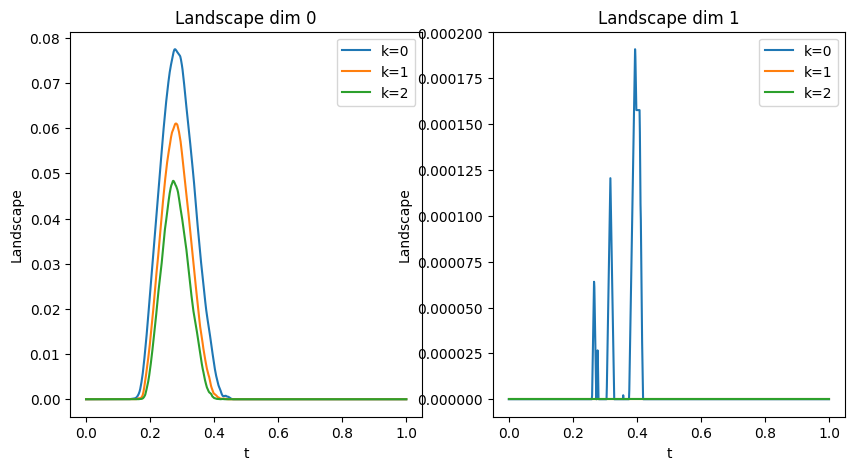

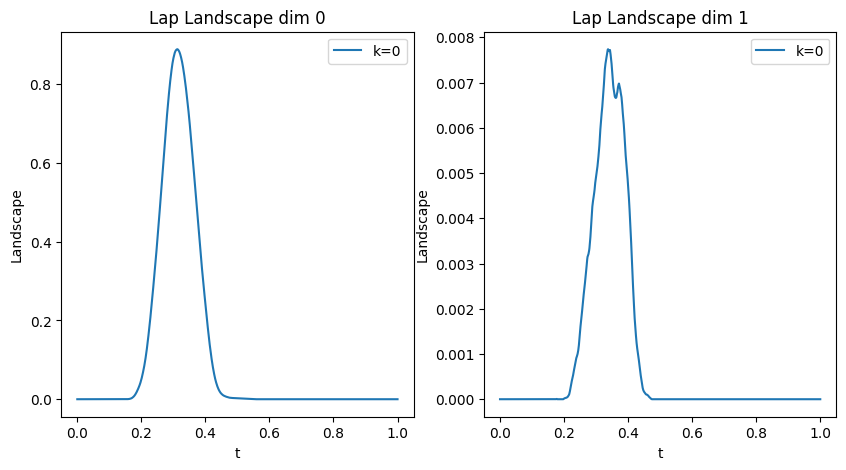

In [15]:
np.mean(land_dict[eps][color]["HC"]["normal"]).plot()
np.mean(land_dict[eps][color]["HC"]["laplacian"]).plot()

In [16]:
# partial_dict = {"HC": {"HC": [], "cluster": [], "PV": []}, "cluster": {"HC": [], "cluster": [], "PV": []}, "PV": {"HC": [], "cluster": [], "PV": []}}
# laplacian_dict = {"alpha": deepcopy(partial_dict), "grad": deepcopy(partial_dict), "random": deepcopy(partial_dict)}
distances_dict = {}

# method, color, land_type 
for eps in land_dict.keys():
    distances_dict[eps] = {}
    for color in land_dict[eps].keys():
        distances_dict[eps][color] = {}
        if color == "alpha":
            start_from = 100
        else:
            start_from = 50
        for initial_method in tqdm(land_dict[eps][color].keys(), leave=False):
            distances_dict[eps][color][initial_method] = {}
            
            average_land = np.mean(land_dict[eps][color][initial_method]["normal"][:start_from])
            average_lap_land = np.mean(land_dict[eps][color][initial_method]["laplacian"][:start_from])

            for new_method in land_dict[eps][color].keys():
                distances_dict[eps][color][initial_method][new_method] = {"normal": [], "laplacian": []}
                
                for new_land in land_dict[eps][color][new_method]["normal"][start_from:]:
                    distances_dict[eps][color][initial_method][new_method]["normal"].append((average_land - new_land).sum_k().norm())
                for new_land in land_dict[eps][color][new_method]["laplacian"][start_from:]:
                    distances_dict[eps][color][initial_method][new_method]["laplacian"].append((average_lap_land - new_land).norm(dim=0))
                

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

/tmp/ipykernel_4623/1945691325.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax[0].boxplot([distances_dict[eps][color][initial_method]["PV"]["laplacian"],
/tmp/ipykernel_4623/1945691325.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax[1].boxplot([distances_dict[eps][color][initial_method]["PV"]["normal"],
/tmp/ipykernel_4623/1945691325.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


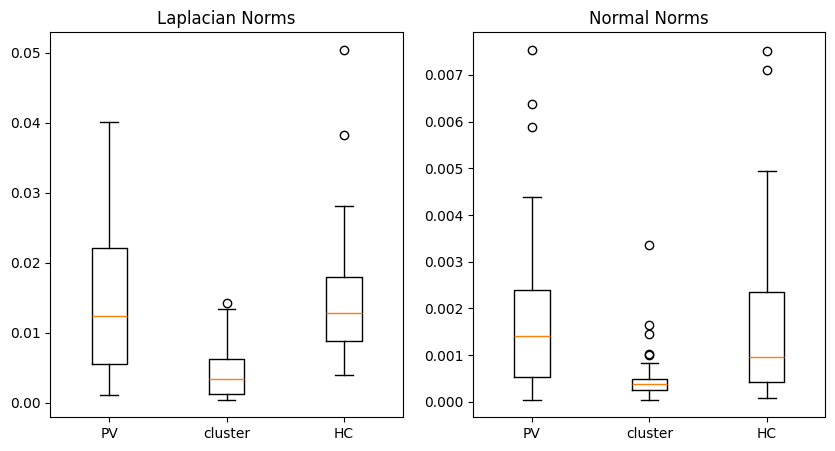

In [55]:
initial_method = "cluster"
color = "random_124"
# land_type = "laplacian"
eps = 25

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].boxplot([distances_dict[eps][color][initial_method]["PV"]["laplacian"], 
             distances_dict[eps][color][initial_method]["cluster"]["laplacian"], 
             distances_dict[eps][color][initial_method]["HC"]["laplacian"]], 
             labels=["PV", 
                     "cluster", 
                     "HC"],
             showfliers=True)
ax[0].set_title("Laplacian Norms")

ax[1].boxplot([distances_dict[eps][color][initial_method]["PV"]["normal"], 
             distances_dict[eps][color][initial_method]["cluster"]["normal"], 
             distances_dict[eps][color][initial_method]["HC"]["normal"]], 
             labels=["PV", 
                     "cluster", 
                     "HC"],
             showfliers=True)
ax[1].set_title("Normal Norms")

fig.show()

In [56]:
# partial_dict = {"HC": {"HC": [], "cluster": [], "PV": []}, "cluster": {"HC": [], "cluster": [], "PV": []}, "PV": {"HC": [], "cluster": [], "PV": []}}
# laplacian_dict = {"alpha": deepcopy(partial_dict), "grad": deepcopy(partial_dict), "random": deepcopy(partial_dict)}
distances_dict_new_filtration = {}

# method, color, land_type 
for eps in land_dict_new_filtration.keys():
    distances_dict_new_filtration[eps] = {}
    for color in land_dict_new_filtration[eps].keys():
        distances_dict_new_filtration[eps][color] = {}
        if color == "alpha":
            start_from = 100
        else:
            start_from = 50
        for initial_method in tqdm(land_dict_new_filtration[eps][color].keys(), leave=False):
            distances_dict_new_filtration[eps][color][initial_method] = {}
            
            average_land = np.mean(land_dict_new_filtration[eps][color][initial_method]["normal"][:start_from])
            average_lap_land = np.mean(land_dict_new_filtration[eps][color][initial_method]["laplacian"][:start_from])

            for new_method in land_dict_new_filtration[eps][color].keys():
                distances_dict_new_filtration[eps][color][initial_method][new_method] = {"normal": [], "laplacian": []}
                
                for new_land in land_dict_new_filtration[eps][color][new_method]["normal"][start_from:]:
                    distances_dict_new_filtration[eps][color][initial_method][new_method]["normal"].append((average_land - new_land).sum_k().norm())
                for new_land in land_dict_new_filtration[eps][color][new_method]["laplacian"][start_from:]:
                    distances_dict_new_filtration[eps][color][initial_method][new_method]["laplacian"].append((average_lap_land - new_land).norm(dim=0))

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

/tmp/ipykernel_4623/3925043674.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax[0,0].boxplot([distances_dict[eps][color][initial_method]["PV"]["laplacian"],
/tmp/ipykernel_4623/3925043674.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax[0,1].boxplot([distances_dict[eps][color][initial_method]["PV"]["normal"],
/tmp/ipykernel_4623/3925043674.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax[1,0].boxplot([distances_dict_new_filtration[eps][color][initial_method]["PV"]["laplacian"],
/tmp/ipykernel_4623/3925043674.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed '

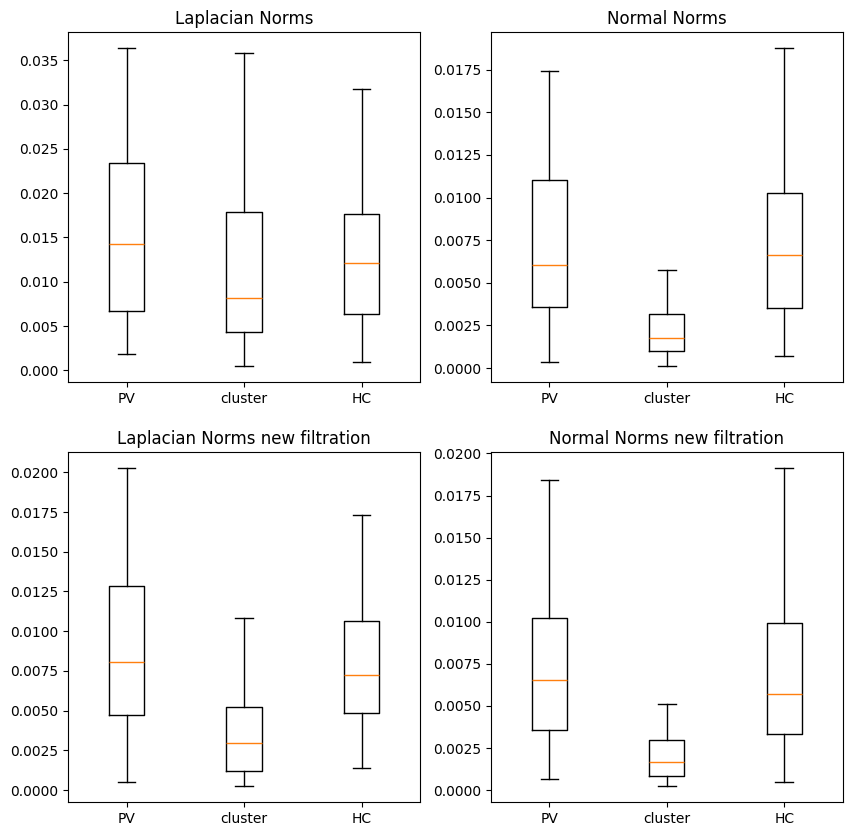

In [89]:
initial_method = "cluster"
color = "random_124"
# land_type = "laplacian"
eps = 10
showfliers = False

fig, ax = plt.subplots(2,2, figsize=(10,10))

ax[0,0].boxplot([distances_dict[eps][color][initial_method]["PV"]["laplacian"], 
             distances_dict[eps][color][initial_method]["cluster"]["laplacian"], 
             distances_dict[eps][color][initial_method]["HC"]["laplacian"]], 
             labels=["PV", 
                     "cluster", 
                     "HC"],
             showfliers=showfliers)
ax[0,0].set_title("Laplacian Norms")

ax[0,1].boxplot([distances_dict[eps][color][initial_method]["PV"]["normal"], 
             distances_dict[eps][color][initial_method]["cluster"]["normal"], 
             distances_dict[eps][color][initial_method]["HC"]["normal"]], 
             labels=["PV", 
                     "cluster", 
                     "HC"],
             showfliers=showfliers)
ax[0,1].set_title("Normal Norms")

ax[1,0].boxplot([distances_dict_new_filtration[eps][color][initial_method]["PV"]["laplacian"], 
             distances_dict_new_filtration[eps][color][initial_method]["cluster"]["laplacian"], 
             distances_dict_new_filtration[eps][color][initial_method]["HC"]["laplacian"]], 
             labels=["PV", 
                     "cluster", 
                     "HC"],
             showfliers=showfliers)
ax[1,0].set_title("Laplacian Norms new filtration")

ax[1,1].boxplot([distances_dict_new_filtration[eps][color][initial_method]["PV"]["normal"], 
             distances_dict_new_filtration[eps][color][initial_method]["cluster"]["normal"], 
             distances_dict_new_filtration[eps][color][initial_method]["HC"]["normal"]], 
             labels=["PV", 
                     "cluster", 
                     "HC"],
             showfliers=showfliers)
ax[1,1].set_title("Normal Norms new filtration")

fig.show()

In [4]:
land_dict = {"HC": {"alpha": {}, "grad": {}, "random": {}}, "cluster": {"alpha": {}, "grad": {}, "random": {}}, "PV": {"alpha": {}, "grad": {}, "random": {}}}
for land_file in sorted([file for file in os.listdir("../landscapes/") if file.endswith(".pkl")]):
    method, seed, color, land_type = land_file.split(".")[0].split("_")
    with open("../landscapes/" + land_file, "rb") as f:
        land = pickle.load(f)

    if land_type not in land_dict[method][color].keys():
        land_dict[method][color][land_type] = [land]
    else:
        land_dict[method][color][land_type].append(land)

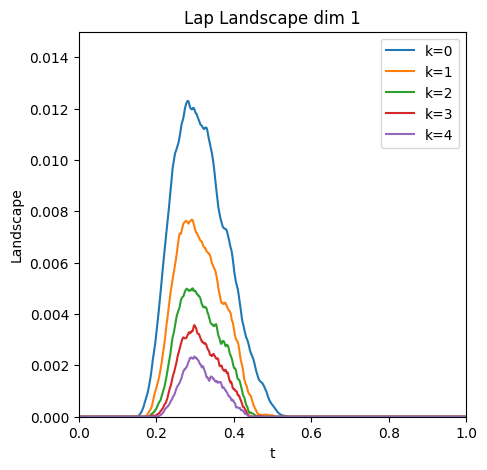

In [66]:
np.mean(land_dict["HC"]["random"]["lap"]).plot(limits=[0,1, 0, 0.015], max_k=5)

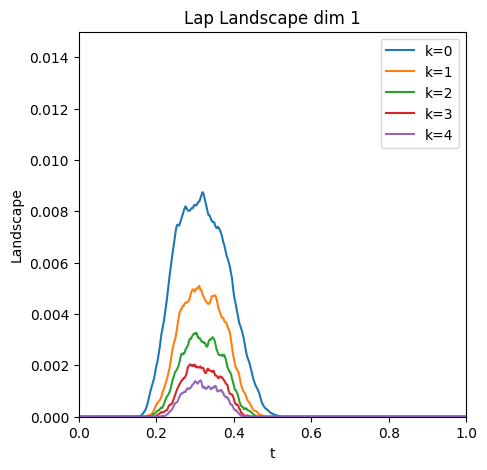

In [68]:
np.mean(land_dict["cluster"]["random"]["lap"]).plot(limits=[0,1, 0, 0.015], max_k=5)

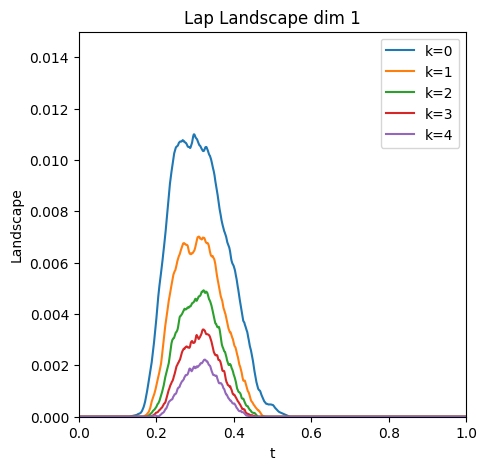

In [70]:
np.mean(land_dict["PV"]["random"]["lap"]).plot(limits=[0,1, 0, 0.015], max_k=5)

7.03143410368579e-07

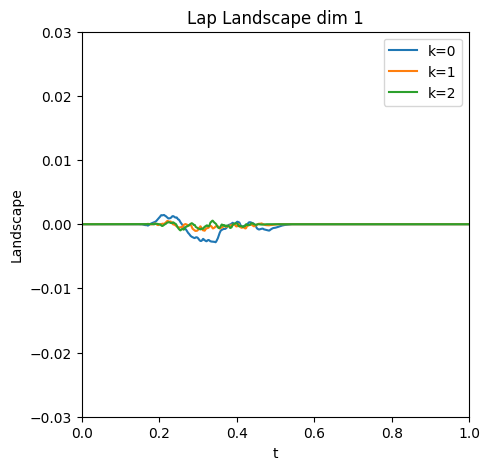

In [60]:
first_method = "PV"
second_method = "HC"

(np.mean(land_dict[first_method]["random"]["lap"][:50])-np.mean(land_dict[second_method]["random"]["lap"][50:])).plot(limits=[0,1,-0.03,0.03])
(np.mean(land_dict[first_method]["random"]["lap"][:50])-np.mean(land_dict[second_method]["random"]["lap"][50:])).norm()

In [30]:
(np.mean(land_dict["PV"]["random"]["lap"][:50])-np.mean(land_dict["PV"]["random"]["lap"][50:])).norm()

5.353742568592428e-07

In [19]:
partial_dict = {"HC": {"HC": [], "cluster": [], "PV": []}, "cluster": {"HC": [], "cluster": [], "PV": []}, "PV": {"HC": [], "cluster": [], "PV": []}}
norm_dict = {"alpha": deepcopy(partial_dict), "grad": deepcopy(partial_dict), "random": deepcopy(partial_dict)}

# method, color, land_type 
for color in ["alpha", "grad", "random"]:
    for initial_method in ["HC", "cluster", "PV"]:
        average_land = np.mean(land_dict[initial_method][color]["norm"][:50])
        for method in ["HC", "cluster", "PV"]:
            for new_land in land_dict[method][color]["norm"][50:]:
                norm_dict[color][initial_method][method].append((average_land - new_land).sum_k().norm())


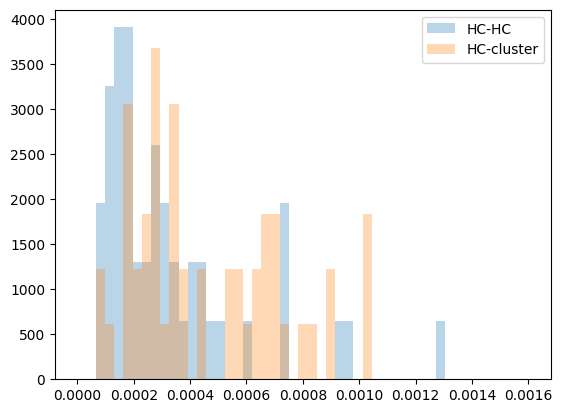

In [6]:
bins = np.linspace(0,0.0016, 50)#np.linspace(0,0.6e-5,100)
plt.hist(norm_dict["random"]["HC"]["HC"], bins=bins, alpha=0.3, label="HC-HC", density=True)
plt.hist(norm_dict["random"]["HC"]["cluster"], bins=bins, alpha=0.3, label="HC-cluster", density=True)
# plt.hist(norm_dict["random"]["HC"]["PV"], bins=bins, alpha=0.3, label="HC-PV", density=True)
plt.legend()

In [6]:
partial_dict = {"HC": {"HC": [], "cluster": [], "PV": []}, "cluster": {"HC": [], "cluster": [], "PV": []}, "PV": {"HC": [], "cluster": [], "PV": []}}
laplacian_dict = {"alpha": deepcopy(partial_dict), "grad": deepcopy(partial_dict), "random": deepcopy(partial_dict)}

# method, color, land_type 
for color in ["alpha", "grad", "random"]:
    for initial_method in ["HC", "cluster", "PV"]:
        average_land = np.mean(land_dict[initial_method][color]["lap"][:50])
        for method in ["HC", "cluster", "PV"]:
            for new_land in land_dict[method][color]["lap"][50:]:
                laplacian_dict[color][initial_method][method].append((average_land - new_land).norm(sum_first=True))

/tmp/ipykernel_1046/756622207.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax[0].boxplot([laplacian_dict[color][ori_method]["PV"], laplacian_dict[color][ori_method]["cluster"], laplacian_dict[color][ori_method]["HC"]], labels=["PV", "cluster", "HC"], showfliers=False)
/tmp/ipykernel_1046/756622207.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax[1].boxplot([norm_dict[color][ori_method]["PV"], norm_dict[color][ori_method]["cluster"], norm_dict[color][ori_method]["HC"]], labels=["PV", "cluster", "HC"], showfliers=False)
/tmp/ipykernel_1046/756622207.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


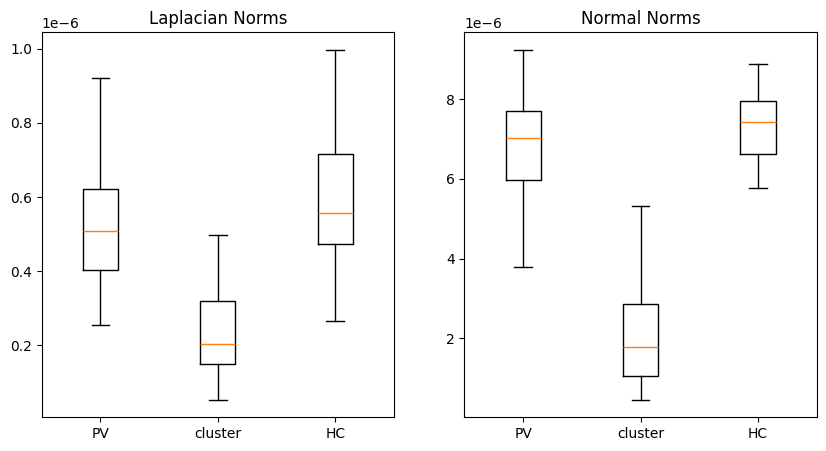

In [20]:
ori_method = "cluster"
color = "alpha"
# plt.boxplot()
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].boxplot([laplacian_dict[color][ori_method]["PV"], laplacian_dict[color][ori_method]["cluster"], laplacian_dict[color][ori_method]["HC"]], labels=["PV", "cluster", "HC"], showfliers=False)
ax[0].set_title("Laplacian Norms")
ax[1].boxplot([norm_dict[color][ori_method]["PV"], norm_dict[color][ori_method]["cluster"], norm_dict[color][ori_method]["HC"]], labels=["PV", "cluster", "HC"], showfliers=False)
ax[1].set_title("Normal Norms")
fig.show()

/tmp/ipykernel_17233/2744873521.py:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([norm_dict[color][ori_method]["PV"], norm_dict[color][ori_method]["cluster"], norm_dict[color][ori_method]["HC"]], labels=["PV", "cluster", "HC"])


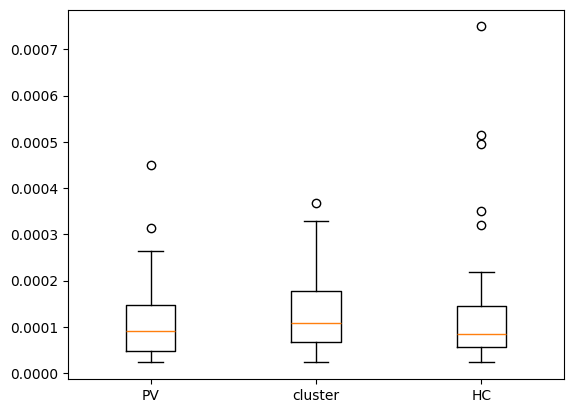

In [24]:
import pickle

with open("test.pkl", "wb") as f:
    pickle.dump(lap_land.__mult__(1), f)


TypeError: __init__() got an unexpected keyword argument 'min_dim'

In [ ]:
with open("test.pkl", "rb") as f:
    evaluations = pickle.load(f)

new_land = Lap_Landscape()

Computing boundary matrices:   0%|          | 0/3260 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

/home/siroj/code/Master_thesis/code/Laplacian_Functions_torch.py:823: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


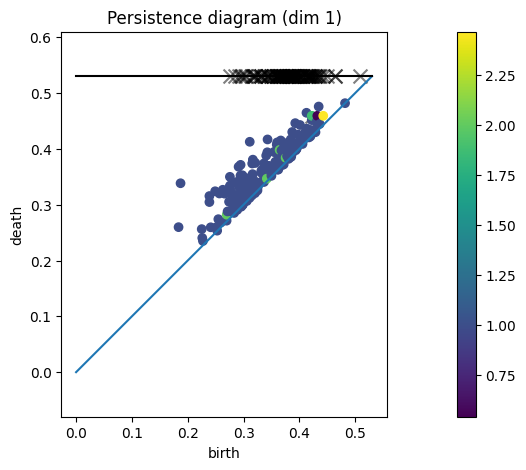

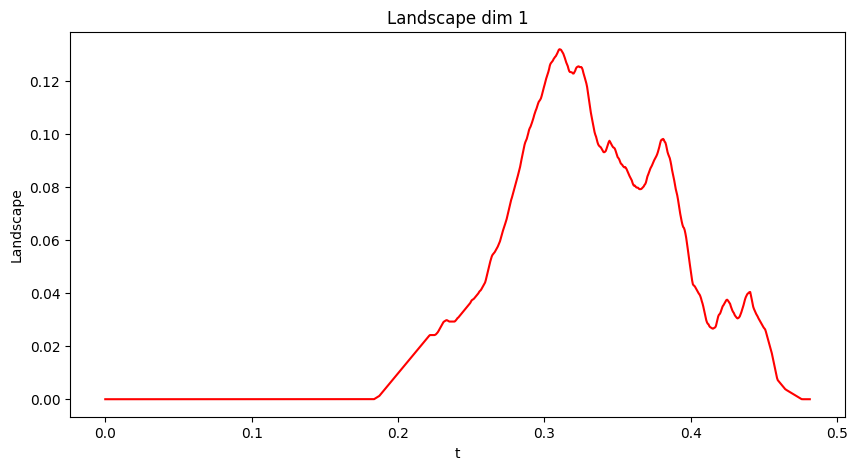

In [8]:
def Laplacian_fun(B22_st, B22_stm1, B22_sm1t, B22_sm1tm1, eye):
    # return B22_stm1@B22_sm1t@(eye-B22_st)@B22_sm1t
    # return B22_sm1t@(eye-B22_st)@B22_sm1t@B22_stm1
    # return B22_sm1t@B22_stm1@(eye-B22_st)@B22_stm1
    # return B22_stm1@(eye-B22_st)@B22_stm1@B22_sm1t
    # return B22_sm1tm1-B22_sm1t-B22_stm1+B22_st

    
    # return B22_stm1@B22_sm1t+B22_sm1t@B22_stm1-2*B22_st
    # return eye-B22_st

    # return B22_stm1@(eye-B22_st)@(eye - B22_sm1tm1 + B22_sm1t)

    # Best
    return B22_sm1t@B22_stm1-B22_st

    # return B22_sm1t+B22_stm1-B22_st-B22_sm1tm1

lap_land2 = Lap_Landscape(f, show_trace_diagram=True, min_dim=1, Laplacian_fun=Laplacian_fun,compute_only_trace=True)
lap_land2.plot()

In [24]:
A = torch.tensor([[1,2,3],[4,5,6],[7,8,9]])
a = torch.trace(A).cpu().numpy().reshape((1))
a

array([15])

In [8]:
calc_cross(f, 1, s=0.3, t=0.5, device="cpu").shape

Computing boundary matrices:   0%|          | 0/3260 [00:00<?, ?it/s]

B22_st^dagger:835940/841776=0.993067039212332


torch.Size([357, 357])

In [9]:
A = torch.tensor([[1,2,3],[4,5,6], [7,8,9]], dtype=torch.float32)
F.pad(A, (0,1,0,1))

tensor([[1., 2., 3., 0.],
        [4., 5., 6., 0.],
        [7., 8., 9., 0.],
        [0., 0., 0., 0.]], dtype=torch.float32)

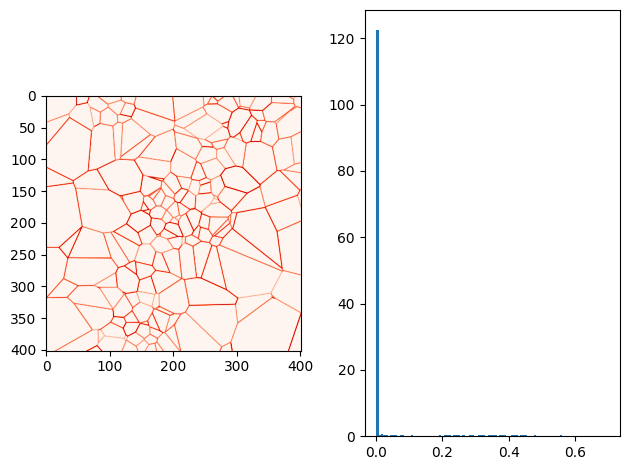

In [16]:
image = images[1]
im_gray = 1-np.array(image.convert("L")).astype(int)/255
fig, ax = plt.subplots(1,2)
ax[0].imshow(im_gray, cmap="Reds")
ax[1].hist(im_gray.flatten(), bins=100, density=True)
fig.tight_layout()
plt.show()

Amount of points: 20611


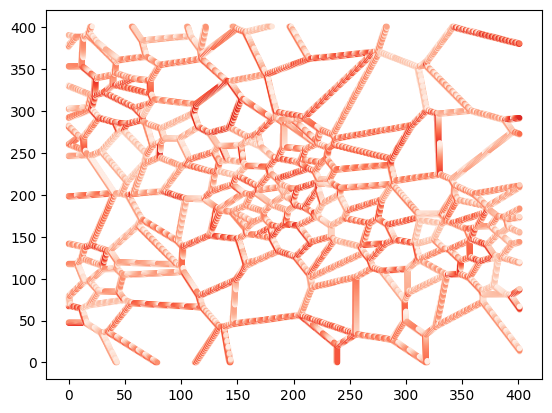

In [17]:
X = np.vstack(np.where(im_gray>np.mean(im_gray))).T
y = np.array([im_gray[X[i,0], X[i,1]] for i in range(X.shape[0])])
print("Amount of points:", len(y))
plt.scatter(X[:,0], X[:,1], marker=".", c=y, cmap="Reds", vmin=0, vmax=1)

In [20]:


# load a labelled dataset
# X, labels = make_circles(n_samples=5000, noise=0.05, factor=0.3, random_state=42)
# y = X[:,1]

cover = CubicalCover(n_intervals=50, overlap_frac=0.3, algorithm="standard")
clust = DBSCAN(eps=5)
graph = MapperAlgorithm(cover, clust).fit_transform(X, X)
print("Mapper done!")

# color according to labels
fig, node_col = MapperPlot(graph, dim=3, seed=45, iterations=60, layout_engine="networkx").plot_plotly(colors=y, cmap="Reds")
fig.show(config={'scrollZoom': True})


Mapper done!
Node_col:
 {1295: 0.49000000000000005, 1294: 0.34252100840336136, 1293: 0.23006535947712417, 1277: 0.3044908285895004, 1292: 0.30206971677559913, 1291: 0.29923273657289007, 1290: 0.35021312872975274, 1289: 0.2619981325863678, 1274: 0.2959001782531195, 1288: 0.35452847805788984, 1286: 0.3140819964349376, 1287: 0.3302696078431372, 1285: 0.3306666666666666, 1283: 0.2260869565217391, 1276: 0.22666666666666668, 1282: 0.23464052287581696, 1281: 0.3680392156862745, 1279: 0.2691764705882353, 1278: 0.26875, 1275: 0.38989898989898986, 1273: 0.29986928104575156, 1272: 0.32254901960784316, 1284: 0.3954248366013072, 1247: 0.4363211951447245, 1271: 0.41106442577030816, 1269: 0.3206220419202162, 1270: 0.40357554786620525, 1268: 0.3033868092691623, 1266: 0.26924369747899163, 1264: 0.3254901960784314, 1263: 0.3563921568627451, 1262: 0.26021505376344084, 1261: 0.33029073698444894, 1246: 0.4278991596638656, 1260: 0.3701812800591934, 1245: 0.31800356506238864, 1259: 0.31078431372549026, 1258:

0.5185185185185185


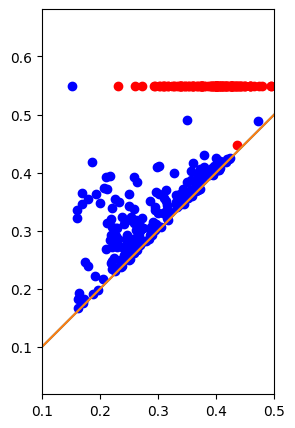

In [21]:


node_col = aggregate_graph(y, graph, agg=np.nanmean)


simplices = []
for c in networkx.enumerate_all_cliques(graph):
    # if len(c) <= 2:
    simplices.append((c, np.max([node_col[i] for i in c])))
f = dio.Filtration()
max_time = 0
for vertices, time in simplices:
    f.append(dio.Simplex(vertices, time))
    max_time = max(max_time, time)
print(max_time)
f.sort()

fig, ax = plt.subplots(1,1, figsize=(3,5))
p = dio.cohomology_persistence(f, 47, True)
dgms = dio.init_diagrams(p, f)
dio.plot.plot_all_diagrams(dgms[:2], ax=ax, limits = (0.1,0.5,0.1,0.55), plot_limits=(0.1,0.5,0.1,0.6))

Computing boundary matrices:   0%|          | 0/1534 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

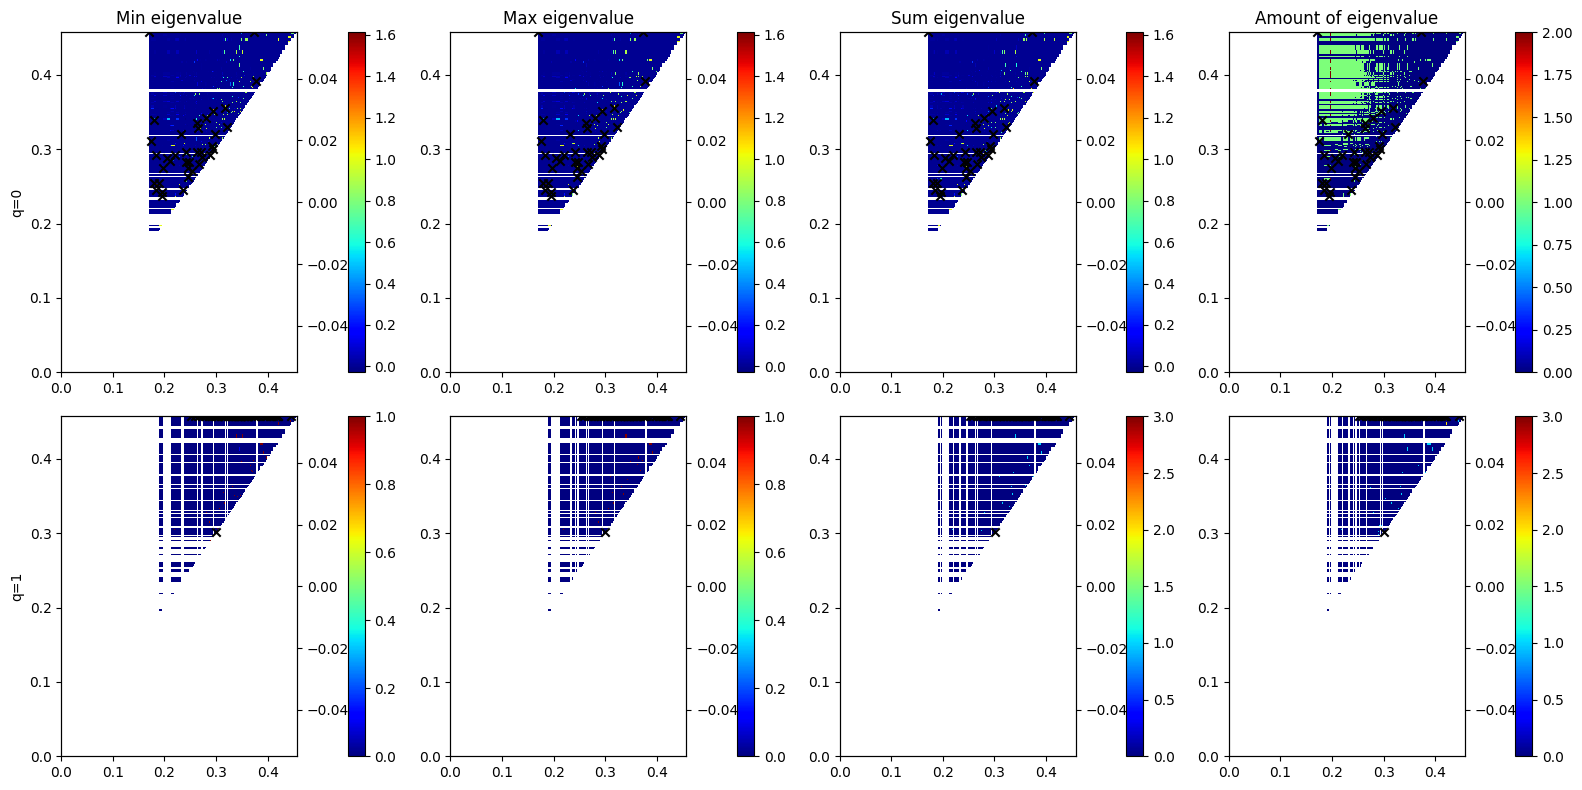

In [42]:
def Laplacian_fun(B22_st, B22_stm1, B22_sm1t, B22_sm1tm1, eye):
    # return B22_sm1t+B22_stm1-B22_st-B22_sm1tm1
    return B22_sm1t@B22_stm1-B22_st

eigenvalues, relevant_times, fig, ax = plot_Laplacian_new_eigenvalues(f, lambda x: 1, max_dim =1, device = "cpu", plot_types=["Min", "Max", "Sum", "Amount of"], Laplacian_fun= Laplacian_fun, method="less_memory", plot_args_diag={"c": "black", "alpha": 1, "marker": "x"}, plot_type_to_fun={"Amount of": len}, integer_time_steps=False)#, device="cpu")

0.17476780712604523 0.310859739780426 1.3381266983358842e-08
0.17476780712604523 0.3115916848182678 0.0054715627164546865
0.17476780712604523 0.31336191296577454 0.00020056569834646376
0.17476780712604523 0.3137255012989044 0.006974144214994704
0.17476780712604523 0.3143937289714813 0.0019864899668480263
0.17476780712604523 0.3173708915710449 0.044372188001382595
0.17476780712604523 0.31855204701423645 1.7439882891850944e-06
0.17476780712604523 0.32078903913497925 0.0007608694656890125
0.17476780712604523 0.32156863808631897 0.00032774495121307146
0.17476780712604523 0.3223894238471985 6.814450102088365e-06
0.17476780712604523 0.32242250442504883 2.898138485797619e-05
0.17476780712604523 0.3232131600379944 8.729275611810139e-06
0.17476780712604523 0.3249835968017578 0.00013039252678118118
0.17476780712604523 0.3270588219165802 0.0023563437021754396
0.17476780712604523 0.32866984605789185 0.0002576840214030818
0.17476780712604523 0.3292691707611084 0.016227494757808155
0.174767807126045

/tmp/ipykernel_8435/1403029360.py:85: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



([[0.17476780712604523,
   0.17476780712604523,
   0.17476780712604523,
   0.17476780712604523,
   0.17476780712604523,
   0.17476780712604523,
   0.17476780712604523,
   0.17476780712604523,
   0.17476780712604523,
   0.17476780712604523,
   0.17476780712604523,
   0.17476780712604523,
   0.17476780712604523,
   0.17476780712604523,
   0.17476780712604523,
   0.17476780712604523,
   0.17476780712604523,
   0.17476780712604523,
   0.17476780712604523,
   0.17476780712604523,
   0.17476780712604523,
   0.17476780712604523,
   0.17476780712604523,
   0.17476780712604523,
   0.17476780712604523,
   0.17476780712604523,
   0.17476780712604523,
   0.17476780712604523,
   0.17476780712604523,
   0.17476780712604523,
   0.17476780712604523,
   0.17476780712604523,
   0.17476780712604523,
   0.17476780712604523,
   0.17476780712604523,
   0.17476780712604523,
   0.17476780712604523,
   0.17476780712604523,
   0.17476780712604523,
   0.17476780712604523,
   0.17476780712604523,
   0.17476780712

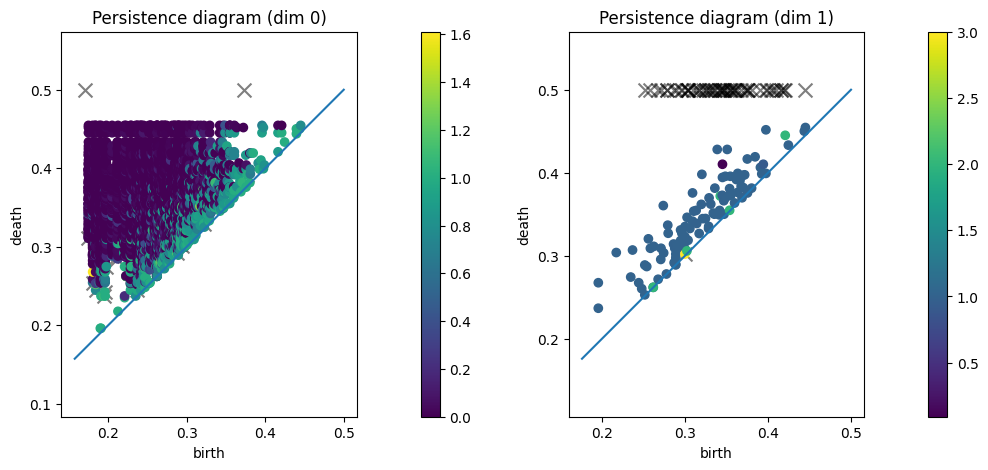

In [43]:
def plot_trace_diagram(f, eigenvalues, show=False, max_dim=2,
                 line_style=None, pt_style_normal=None,
                 limits = None):

    p = dio.cohomology_persistence(f, 47, True)
    dgms = dio.init_diagrams(p, f)
    if show:
        fig, ax = plt.subplots(1, max_dim+1, figsize=(6*(max_dim+1),5))

    s_lists = []
    t_lists = []
    cmaps = []

    for q, dgm in enumerate(dgms):
        if q > max_dim:
            break

        line_kwargs = {}
        pt_kwargs = {"c": "black", "marker": "x", "alpha": 0.5, "s": 100}
        if pt_style_normal is not None:
            pt_kwargs.update(pt_style_normal)
        if line_style is not None:
            line_kwargs.update(line_style)


        inf = float('inf')

        s_list = []
        t_list = []
        cmap = []
        for s in eigenvalues[q].keys():
            for t in eigenvalues[q][s].keys():
                eval_sum = np.sum(eigenvalues[q][s][t])
                if eval_sum > 1e-10:
                    if eval_sum < 0.1:
                        print(s, t, eval_sum)
                    s_list.append(s)
                    t_list.append(t)
                    cmap.append(eval_sum)

        s_lists.append(s_list)
        t_lists.append(t_list)
        cmaps.append(cmap)

        min_diag = np.min(s_list)*0.9
        max_diag = np.max(t_list)*1.1
        # min_birth,max_birth,min_death,max_death = inf,-1,inf,-1
        # if not limits:
        #     min_birth = min(min_birth, min((p.birth for p in dgm))*0.9)
        #     max_birth = max(max_birth, max((p.birth for p in dgm)))

        #     for p in dgm:
        #         if p.death != inf:
        #             max_death = max(max_death, max((p.death for p in dgm if p.death != inf))*1.1)
        #             break
        #     if max_death == -1:
        #         max_death = max_birth*1.1
        # else:
        #     min_birth, max_birth, min_death, max_death = limits


        if show:
            ax[q].set_aspect('equal', 'datalim')

            ax[q].scatter([p.birth for p in dgm], [p.death if p.death != inf else max_diag for p in dgm], **pt_kwargs)

       

        if show:
            scatter_im = ax[q].scatter(s_list, t_list, c=cmap)
            plt.colorbar(scatter_im, ax=ax[q], pad=0.15)

            
            ax[q].plot([min_diag, max_diag], [min_diag, max_diag], **line_kwargs)

            ax[q].set_xlabel('birth')
            ax[q].set_ylabel('death')
            ax[q].set_title(f"Persistence diagram (dim {q})")

        ## clip the view
        #plt.axes().set_xlim([min_birth, max_birth])
        #plt.axes().set_ylim([min_death, max_death])

    if show:
        fig.show()
    return s_lists, t_lists, cmaps

plot_trace_diagram(f, eigenvalues, show=True, max_dim=1)

0.5225645899772644 0.5671957731246948 0.028329725164502446
0.5292765498161316 0.595710813999176 0.07764202039585093
0.5331628322601318 0.5427259802818298 0.0847058823529417
0.5333333611488342 0.5749402046203613 0.016932416044536935
0.5333333611488342 0.5760164856910706 0.01041293297551124
0.5333333611488342 0.598753035068512 0.09054598393932953
0.5333333611488342 0.6223079562187195 0.014857231706312223
0.5333333611488342 0.6230533719062805 0.027355047719302333
0.5333333611488342 0.6240805387496948 0.034756166278624503
0.5333333611488342 0.6277138590812683 0.01306469196500581
0.5370880365371704 0.5478991866111755 0.012525837577116663
0.5370880365371704 0.595710813999176 0.012619098198800421
0.5384417176246643 0.5602139234542847 0.05064729174019221
0.5384417176246643 0.561755895614624 0.0797218669050217
0.5384417176246643 0.5671957731246948 0.029985725321058875
0.5384417176246643 0.598753035068512 0.058062857779739546
0.5384417176246643 0.6094560623168945 0.02999357722107197
0.5384417176

/tmp/ipykernel_137657/2735975572.py:85: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


([[0.5225645899772644,
   0.5225645899772644,
   0.5292765498161316,
   0.5292765498161316,
   0.5292765498161316,
   0.5292765498161316,
   0.5292765498161316,
   0.5331628322601318,
   0.5331628322601318,
   0.5333333611488342,
   0.5333333611488342,
   0.5333333611488342,
   0.5333333611488342,
   0.5333333611488342,
   0.5333333611488342,
   0.5333333611488342,
   0.5333333611488342,
   0.5333333611488342,
   0.5333333611488342,
   0.5333333611488342,
   0.5370880365371704,
   0.5370880365371704,
   0.5370880365371704,
   0.5370880365371704,
   0.5384417176246643,
   0.5384417176246643,
   0.5384417176246643,
   0.5384417176246643,
   0.5384417176246643,
   0.5384417176246643,
   0.5384417176246643,
   0.5384417176246643,
   0.5384417176246643,
   0.5384417176246643,
   0.5384417176246643,
   0.5384417176246643,
   0.5384417176246643,
   0.5384417176246643,
   0.5384417176246643,
   0.5384417176246643,
   0.5411342978477478,
   0.5411342978477478,
   0.5411342978477478,
   0.541134

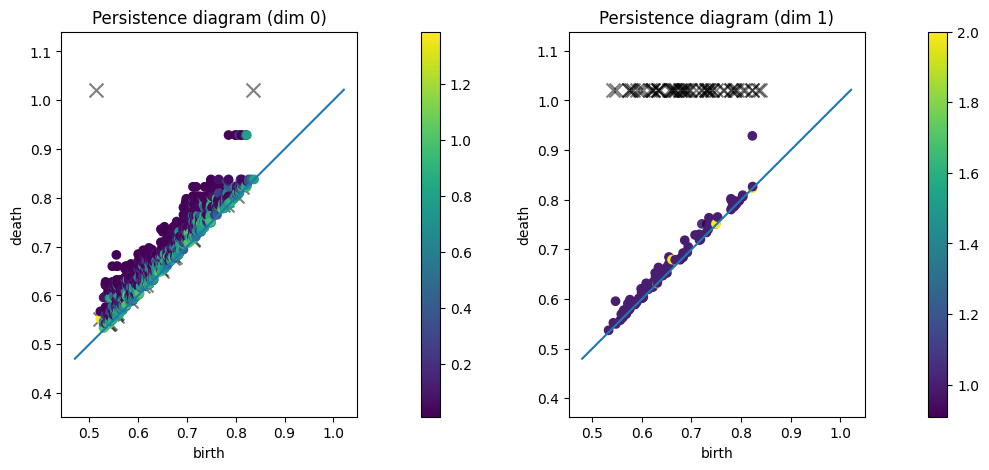

In [35]:
plot_trace_diagram(f, eigenvalues, show=True, max_dim=1)

In [23]:
for i, key in enumerate(eigenvalues[0].keys()):
    if i > 20:
        if key != 0:
            print(eigenvalues[0][key])
            break

{0.0: array([], dtype=float64), 0.5129411816596985: array([], dtype=float64), 0.5225645899772644: array([], dtype=float64), 0.5292765498161316: array([], dtype=float64), 0.5331628322601318: array([], dtype=float64), 0.5333333611488342: array([], dtype=float64), 0.5370880365371704: array([], dtype=float64), 0.5384417176246643: array([], dtype=float64), 0.5411342978477478: array([], dtype=float64), 0.5420083403587341: array([], dtype=float64), 0.5424509644508362: array([], dtype=float64), 0.5427259802818298: array([], dtype=float64), 0.5470588207244873: array([], dtype=float64), 0.5470824241638184: array([], dtype=float64), 0.5478991866111755: array([], dtype=float64), 0.5499311089515686: array([], dtype=float64), 0.5521529912948608: array([], dtype=float64), 0.5553569793701172: array([], dtype=float64), 0.5557355880737305: array([], dtype=float64), 0.5568194389343262: array([], dtype=float64), 0.5572192668914795: array([], dtype=float64), 0.5575630068778992: array([], dtype=float64), 0.

In [ ]:
from sklearn.svm import SVC

method = "normal"
C = 100
color = "gradient"
# q = 1

# LogisticRegression().fit()
# PV_part = []
# for i in range(80):
#     helper = []
#     for q in range(2):

#         helper.append(land_dict[color]["PV"][method][i].sum_k().evaluations[q][0])
#     PV_part.append(np.hstack([land_dict[color]["PV"][method][i].sum_k().evaluations[q][0] for q in range(2)]))
PV_part = np.vstack([np.hstack([np.zeros(1000) if 0 not in land_dict[color]["PV"][method][i].sum_k().evaluations[q].keys() else land_dict[color]["PV"][method][i].sum_k().evaluations[q][0] for q in range(2)]) for i in range(80)])

# cluster_part = np.vstack([np.hstack([np.zeros(1000) if 0 not in land_dict[color]["cluster"][method][i].sum_k().evaluations[q].keys() else land_dict[color]["cluster"][method][i].sum_k().evaluations[q][0] for q in range(2)]) for i in range(80)])
HC_part = np.vstack([np.hstack([np.zeros(1000) if 0 not in land_dict[color]["HC"][method][i].sum_k().evaluations[q].keys() else land_dict[color]["HC"][method][i].sum_k().evaluations[q][0] for q in range(2)]) for i in range(80)])

# X_train = np.vstack([PV_part, cluster_part])
# y = np.array([0]*80 + [1]*80)

# X_train = np.vstack([PV_part, cluster_part, HC_part])
# y = np.array([0]*80 + [1]*80 + [2]*80)

X_train = np.vstack([PV_part, HC_part])
y = np.array([0]*80 + [1]*80)


clf = SVC(C = C, max_iter=100000, random_state=123)
clf.fit(X_train, y)


PV_part = np.vstack([np.hstack([np.zeros(1000) if 0 not in land_dict[color]["PV"][method][i].sum_k().evaluations[q].keys() else land_dict[color]["PV"][method][i].sum_k().evaluations[q][0] for q in range(2)]) for i in range(80, 100)])
# cluster_part = np.vstack([np.hstack([np.zeros(1000) if 0 not in land_dict[color]["cluster"][method][i].sum_k().evaluations[q].keys() else land_dict[color]["cluster"][method][i].sum_k().evaluations[q][0] for q in range(2)]) for i in range(80, 100)])
HC_part = np.vstack([np.hstack([np.zeros(1000) if 0 not in land_dict[color]["HC"][method][i].sum_k().evaluations[q].keys() else land_dict[color]["HC"][method][i].sum_k().evaluations[q][0] for q in range(2)]) for i in range(80, 97)])

# X_val = np.vstack([PV_part, cluster_part])
# y_val = np.array([0]*20 + [1]*20)

# X_val = np.vstack([PV_part, cluster_part, HC_part])
# y_val = np.array([0]*20 + [1]*20 + [2]*17)

X_val = np.vstack([PV_part, HC_part])
y_val = np.array([0]*20 + [1]*17)

# Predict on new data
predictions = clf.predict(X_val)
# Calculate accuracy
accuracy = np.mean(predictions == y_val)
print(f"Validation accuracy: {accuracy}")